In [1]:
pip install yfinance pandas scikit-learn matplotlib prophet

In [2]:
import yfinance as yf
import pandas as pd

tickers = ['AAPL', 'MSFT', 'NVDA']
data = {}
for ticker in tickers:
    company = yf.Ticker(ticker)
    financials = company.financials.T
    balance = company.balance_sheet.T
    data[ticker] = financials.join(balance, lsuffix='_fin', rsuffix='_bal')

df = pd.concat(data)
df.reset_index(inplace=True)

/tmp/ipython-input-4065526261.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)
/tmp/ipython-input-4065526261.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)


In [3]:
df.head()

,level_0,level_1,Tax Effect Of Unusual Items,Tax Rate For Calcs,Normalized EBITDA,Net Income From Continuing Operation Net Minority Interest,Reconciled Depreciation,Reconciled Cost Of Revenue,EBITDA,EBIT,...,Additional Paid In Capital,Preferred Stock,Employee Benefits,Current Provisions,Current Accrued Expenses,Interest Payable,Non Current Prepaid Assets,Non Current Accounts Receivable,Construction In Progress,Prepaid Assets
0,AAPL,2024-09-30,0.0,0.241,1.346610e+11,9.373600e+10,1.144500e+10,2.103520e+11,1.346610e+11,1.232160e+11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2023-09-30,0.0,0.147,1.258200e+11,9.699500e+10,1.151900e+10,2.141370e+11,1.258200e+11,1.143010e+11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAPL,2022-09-30,0.0,0.162,1.305410e+11,9.980300e+10,1.110400e+10,2.235460e+11,1.305410e+11,1.194370e+11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAPL,2021-09-30,0.0,0.133,1.231360e+11,9.468000e+10,1.128400e+10,2.129810e+11,1.231360e+11,1.118520e+11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MSFT,2025-06-30,-77088000.0,0.176,1.606030e+11,1.018320e+11,3.415300e+10,8.783100e+10,1.601650e+11,1.260120e+11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print(df.columns.tolist())

['level_0', 'level_1', 'Tax Effect Of Unusual Items', 'Tax Rate For Calcs', 'Normalized EBITDA', 'Net Income From Continuing Operation Net Minority Interest', 'Reconciled Depreciation', 'Reconciled Cost Of Revenue', 'EBITDA', 'EBIT', 'Net Interest Income', 'Interest Expense', 'Interest Income', 'Normalized Income', 'Net Income From Continuing And Discontinued Operation', 'Total Expenses', 'Total Operating Income As Reported', 'Diluted Average Shares', 'Basic Average Shares', 'Diluted EPS', 'Basic EPS', 'Diluted NI Availto Com Stockholders', 'Net Income Common Stockholders', 'Net Income', 'Net Income Including Noncontrolling Interests', 'Net Income Continuous Operations', 'Tax Provision', 'Pretax Income', 'Other Income Expense', 'Other Non Operating Income Expenses', 'Net Non Operating Interest Income Expense', 'Interest Expense Non Operating', 'Interest Income Non Operating', 'Operating Income', 'Operating Expense', 'Research And Development', 'Selling General And Administration', 'Gro

In [5]:
import pandas as pd
# --- pick correct columns robustly ---
def pick(col_substrings):
    for s in col_substrings:
        hits = [c for c in df.columns if s.lower() in c.lower()]
        if hits: return hits[0]
    raise KeyError(col_substrings)

LIAB  = pick(["Total Liabilities Net Minority Interest", "Total Liabilities", "Total Liab"])
ASSET = pick(["Total Assets"])
REV   = pick(["Total Revenue"])
OPINC = pick(["Operating Income"])
NET   = pick(["Net Income"])

# --- clean index & time ---
df = df.rename(columns={"level_0":"Ticker","level_1":"Period"})
df["Period"] = pd.to_datetime(df["Period"])
df = df.sort_values(["Ticker","Period"])

# --- core KPIs (with safe division) ---
eps = 1e-9
df["Debt Ratio"]       = df[LIAB] / (df[ASSET] + eps)
df["Operating Margin"] = df[OPINC] / (df[REV] + eps)
df["Profit Margin"]    = df[NET]   / (df[REV] + eps)

# --- growth & lag features per ticker ---
df["Revenue Growth"] = df.groupby("Ticker")[REV].pct_change()
for k in [REV, OPINC, NET]:
    df[f"{k}_lag1"] = df.groupby("Ticker")[k].shift(1)
    df[f"{k}_lag2"] = df.groupby("Ticker")[k].shift(2)

# --- tidy numeric cols, drop obvious NaNs from first rows of each ticker ---
feat_cols = ["Debt Ratio","Operating Margin","Profit Margin","Revenue Growth",
             f"{REV}_lag1", f"{REV}_lag2", f"{OPINC}_lag1", f"{NET}_lag1"]
df_model = df[["Ticker","Period",REV] + feat_cols].dropna()

In [6]:
df_model[["Ticker","Period",REV,"Debt Ratio","Operating Margin","Profit Margin"]].tail()

,Ticker,Period,Total Revenue,Debt Ratio,Operating Margin,Profit Margin
0,AAPL,2024-09-30,3.910350e+11,0.843964,0.315102,0.239713
5,MSFT,2024-06-30,2.451220e+11,0.475798,0.446443,0.359560
4,MSFT,2025-06-30,2.817240e+11,0.445109,0.456220,0.361460
9,NVDA,2024-01-31,6.092200e+10,0.346123,0.541217,0.488493
8,NVDA,2025-01-31,1.304970e+11,0.289191,0.624175,0.558480


In [7]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
preds = []; scores = {}

for tk, g in df_model.groupby("Ticker"):
    X = g[feat_cols]; y = g[REV]
    split = int(len(g)*0.8)
    Xtr,Xte,ytr,yte = X.iloc[:split],X.iloc[split:],y.iloc[:split],y.iloc[split:]
    mdl = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, subsample=0.9, colsample_bytree=0.9, random_state=42)
    mdl.fit(Xtr, ytr)
    yhat = mdl.predict(Xte)
    scores[tk] = 100*mean_absolute_percentage_error(yte, yhat)  # MAPE %
    # one-step ahead forecast for next quarter:
    last = g.iloc[[-1]][feat_cols]
    preds.append({
    "Ticker": tk,
    "Next_Q_Revenue_Pred": float(mdl.predict(last).item())
})

print("MAPE by ticker (%):", {k: round(v,2) for k,v in scores.items()})
preds

MAPE by ticker (%): {'AAPL': 1.98, 'MSFT': 12.99, 'NVDA': 53.32}


[{'Ticker': 'AAPL', 'Next_Q_Revenue_Pred': 383285002240.0},
 {'Ticker': 'MSFT', 'Next_Q_Revenue_Pred': 245122007040.0},
 {'Ticker': 'NVDA', 'Next_Q_Revenue_Pred': 60921999360.0}]

In [8]:
for p in preds:
    tk = p["Ticker"]
    actual_latest = df_model[df_model["Ticker"]==tk][REV].iloc[-1]
    growth_pred = (p["Next_Q_Revenue_Pred"] - actual_latest) / actual_latest * 100
    print(f"{tk}: Predicted growth next quarter = {growth_pred:.2f}%")

AAPL: Predicted growth next quarter = -1.98%
MSFT: Predicted growth next quarter = -12.99%
NVDA: Predicted growth next quarter = -53.32%


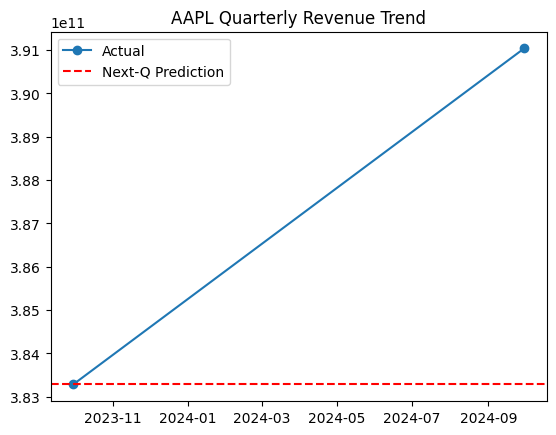

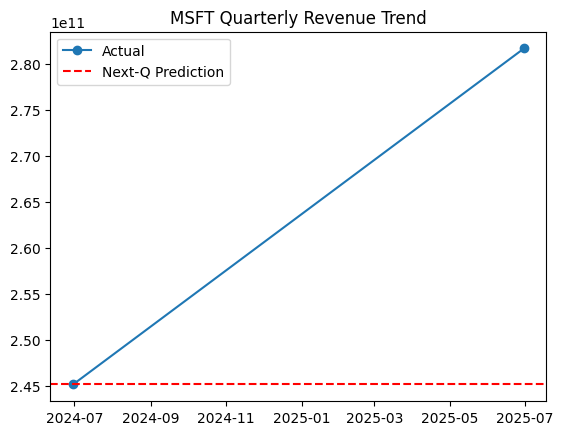

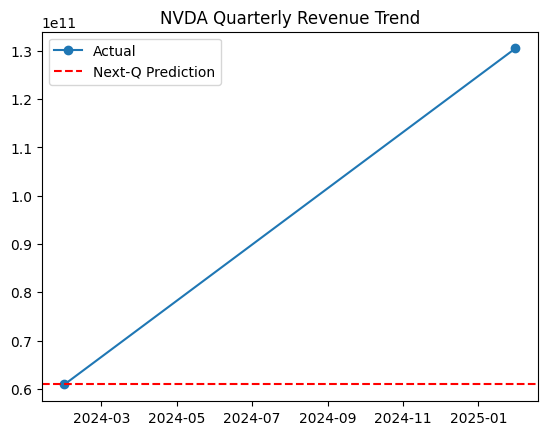

In [9]:
import matplotlib.pyplot as plt
for tk in ['AAPL','MSFT','NVDA']:
    sub = df_model[df_model['Ticker']==tk]
    plt.figure()
    plt.plot(sub['Period'], sub[REV], marker='o', label='Actual')
    plt.axhline([p["Next_Q_Revenue_Pred"] for p in preds if p["Ticker"]==tk][0],
                color='r', linestyle='--', label='Next-Q Prediction')
    plt.title(f"{tk} Quarterly Revenue Trend")
    plt.legend()
    plt.show()

#Cash Flow Forecasting

In [10]:
import yfinance as yf
import pandas as pd

tickers = ['AAPL','MSFT','NVDA']
data = {}

for t in tickers:
    c = yf.Ticker(t)

    fin   = c.financials.T            # income statement
    bal   = c.balance_sheet.T         # balance sheet

    # cash flow can be exposed as .cashflow or .cash_flow depending on yfinance version
    try:
        cf = c.cashflow.T
        if cf is None or cf.empty: raise AttributeError
    except Exception:
        cf = getattr(c, "cash_flow", pd.DataFrame()).T

    # join what’s available
    frames = [fin]
    if not bal.empty: frames.append(bal)
    if cf is not None and not cf.empty: frames.append(cf)

    data[t] = pd.concat(frames, axis=1, join='outer')

df = pd.concat(data)
df.reset_index(inplace=True)

# ---- robust column picking helper
def pick(df_, options):
    for opt in options:
        hits = [c for c in df_.columns if opt.lower() in c.lower()]
        if hits: return hits[0]
    raise KeyError(f"None of {options} found")

# canonical column names (handles Yahoo variants)
LIAB   = pick(df, ["Total Liabilities Net Minority Interest","Total Liabilities","Total Liab"])
ASSET  = pick(df, ["Total Assets"])
REV    = pick(df, ["Total Revenue"])
OPINC  = pick(df, ["Operating Income"])
NET    = pick(df, ["Net Income"])

# cash flow column often appears under different labels
OCF    = pick(df, [
    "Operating Cash Flow",
    "Total Cash From Operating Activities",
    "Net cash provided by operating activities",
    "Net Cash Provided By Operating Activities"
])

# ---- cleanup & features
df = df.rename(columns={"level_0":"Ticker","level_1":"Period"})
df["Period"] = pd.to_datetime(df["Period"])
df = df.sort_values(["Ticker","Period"])

eps = 1e-9
df["Debt Ratio"]       = df[LIAB] / (df[ASSET] + eps)
df["Operating Margin"] = df[OPINC] / (df[REV] + eps)
df["Profit Margin"]    = df[NET]   / (df[REV] + eps)

# Liquidity/quality-of-earnings style KPI
df["OCF_to_NetIncome"] = df[OCF] / (df[NET] + eps)         # >1 is healthy
df["OCF_to_Revenue"]   = df[OCF] / (df[REV] + eps)         # cash conversion

# growth + lags
df["Revenue Growth"] = df.groupby("Ticker")[REV].pct_change()
for k in [REV, OPINC, NET, OCF]:
    df[f"{k}_lag1"] = df.groupby("Ticker")[k].shift(1)

# ready for modeling
feat_cols = ["Debt Ratio","Operating Margin","Profit Margin","Revenue Growth",
             "OCF_to_NetIncome","OCF_to_Revenue",
             f"{REV}_lag1", f"{OPINC}_lag1", f"{NET}_lag1", f"{OCF}_lag1"]
df_model = df[["Ticker","Period",REV] + feat_cols].dropna()

/tmp/ipython-input-4220368561.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)
/tmp/ipython-input-4220368561.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)
/tmp/ipython-input-4220368561.py:67: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Revenue Growth"

In [11]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

scores, preds = {}, []
for tk, g in df.dropna(subset=[REV]+feat_cols).groupby("Ticker"):
    g = g.sort_values("Period").copy()

    # log-transform target for stability
    g["y"] = np.log1p(g[REV])
    X, y = g[feat_cols], g["y"]

    # --- adaptive folds: at least 2, at most len(X)-1
    max_splits = max(2, min(5, len(X) - 1))
    if max_splits < 2:
        # too few samples: skip CV and just fit once
        mdl = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=3,
                           subsample=0.9, colsample_bytree=0.9, random_state=42)
        mdl.fit(X, y)
        next_rev_pred = float(np.expm1(mdl.predict(X.iloc[[-1]])[0]))
        preds.append({"Ticker": tk, "Next_Q_Revenue_Pred": next_rev_pred})
        scores[tk] = None
        continue

    tscv = TimeSeriesSplit(n_splits=max_splits)
    fold_mape = []
    for tr, te in tscv.split(X):
        if len(te) == 0:  # safety
            continue
        mdl = XGBRegressor(n_estimators=600, learning_rate=0.03, max_depth=4,
                           subsample=0.9, colsample_bytree=0.9, random_state=42)
        mdl.fit(X.iloc[tr], y.iloc[tr])
        yhat = mdl.predict(X.iloc[te])
        fold_mape.append(
            100*mean_absolute_percentage_error(np.expm1(y.iloc[te]), np.expm1(yhat))
        )

    scores[tk] = round(float(np.mean(fold_mape)), 2) if fold_mape else None

    # final refit on all data for one-step-ahead
    mdl.fit(X, y)
    next_rev_pred = float(np.expm1(mdl.predict(X.iloc[[-1]])[0]))
    preds.append({"Ticker": tk, "Next_Q_Revenue_Pred": next_rev_pred})

print("TS CV MAPE (%):", scores)
pd.DataFrame(preds)

TS CV MAPE (%): {'AAPL': 2.32, 'MSFT': 13.31, 'NVDA': 54.54}


,Ticker,Next_Q_Revenue_Pred
0,AAPL,3.910579e+11
1,MSFT,2.814010e+11
2,NVDA,1.303452e+11


#or

In [12]:
def safe_qdf(attr_name, ticker_obj):
    # Try quarterly_<name>, fall back to annual
    q = getattr(ticker_obj, f"quarterly_{attr_name}", pd.DataFrame())
    if q is None or q.empty:
        q = getattr(ticker_obj, attr_name, pd.DataFrame())
    return q.T  # we’ll work with rows=time

tickers = ['AAPL','MSFT','NVDA']
data = {}
for t in tickers:
    c = yf.Ticker(t)
    fin = safe_qdf("financials", c)           # quarterly if available
    bal = safe_qdf("balance_sheet", c)
    try:
        cf  = safe_qdf("cashflow", c)
    except Exception:
        cf = safe_qdf("cash_flow", c)

    data[t] = pd.concat([fin, bal, cf], axis=1, join="outer")

df = pd.concat(data)
df.reset_index(inplace=True)
df = df.rename(columns={"level_0":"Ticker","level_1":"Period"})
df["Period"] = pd.to_datetime(df["Period"])
df = df.sort_values(["Ticker","Period"])
# (recompute LIAB/ASSET/REV/OPINC/NET/OCF with your pick() helper and rebuild features)

/tmp/ipython-input-3432702194.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)
/tmp/ipython-input-3432702194.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)


# (1) Add Variance Analysis (Budget vs Actual vs Forecast)

In [13]:
df_model["Budget"] = df_model.groupby("Ticker")[REV].shift(1) * 1.05  # assume 5% growth budget
df_model["Variance_vs_Budget"] = (df_model[REV] - df_model["Budget"]) / df_model["Budget"]
df_model["Variance_vs_Forecast"] = (df_model[REV] - df_model[f"{REV}_lag1"]) / df_model[f"{REV}_lag1"]

# (2) Add Free Cash Flow (FCF) & Cash Flow Coverage Metrics

In [14]:
CAPEX = pick(df, ["Capital Expenditure","Capital Expenditures"])
df["FCF"] = df[OCF] - df[CAPEX]
df["FCF_Margin"] = df["FCF"] / (df[REV] + eps)

# (3) Add Liquidity & Solvency Ratios

In [16]:
curr_assets   = df[pick(df, ["Current Assets"])]
curr_liab     = df[pick(df, ["Current Liabilities"])]
total_liab    = df[pick(df, ["Total Liabilities Net Minority Interest","Total Liabilities"])]
equity        = df[pick(df, ["Stockholders Equity","Total Equity Gross Minority Interest"])]
int_exp       = df[pick(df, ["Interest Expense","Interest Expense Non Operating"])]

df["Current_Ratio"]      = curr_assets / (curr_liab + eps)
df["Debt_to_Equity"]     = total_liab / (equity + eps)
df["Interest_Coverage"]  = df[OPINC] / (int_exp + eps)

# Verify (to make sure nothing is string-typed)

In [17]:
df[["Current_Ratio","Debt_to_Equity","Interest_Coverage"]].dtypes

,0
Current_Ratio,float64
Debt_to_Equity,float64
Interest_Coverage,float64


# (4) Add Expense Forecasting (Biweekly Equivalent)

In [18]:
df_model["Biweekly_Opex"] = df[OPINC].abs() / 6.5  # ~6.5 biweeks per quarter

# (5) KPI Dashboard (Tableau/PowerBI-style in Python)

Skipping missing metric: Revenue Growth
Skipping missing metric: Profit Margin


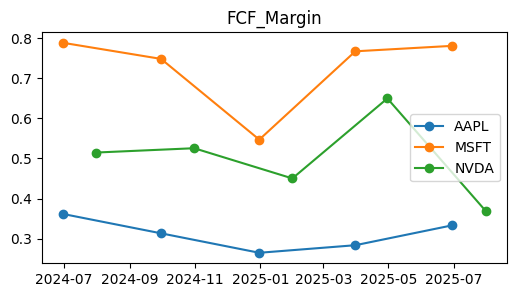

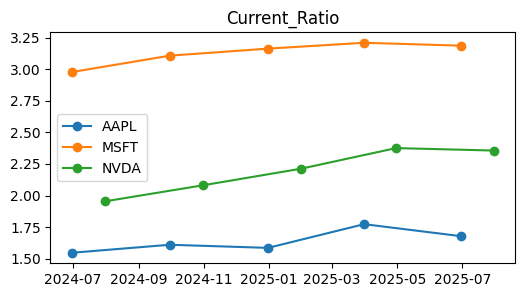

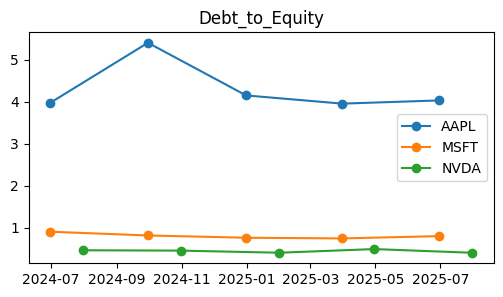

In [21]:
metrics = ["Revenue Growth","Profit Margin","FCF_Margin",
           "Current_Ratio","Debt_to_Equity"]

for m in metrics:
    if m not in df.columns:
        print("Skipping missing metric:", m)
        continue

    df_p = df[["Ticker","Period",m]].dropna()
    plt.figure(figsize=(6,3))
    for tk in df_p["Ticker"].unique():
        sub = df_p[df_p["Ticker"]==tk]
        plt.plot(sub["Period"], sub[m], marker='o', label=tk)
    plt.title(m)
    plt.legend()
    plt.show()

# (6) Trend & Variance Narratives (Like FP&A output)

In [23]:
eps = 1e-9
df["FCF"] = df[OCF] - df[CAPEX]
df["FCF_Margin"] = df["FCF"] / (df[REV] + eps)

# 2) Bring FCF_Margin into df_model
df_model = df_model.merge(
    df[["Ticker","Period","FCF_Margin"]],
    on=["Ticker","Period"],
    how="left"
)

# 3) Now this works:
latest = df_model.groupby("Ticker").tail(1)
for _, row in latest.iterrows():
    print(f"{row['Ticker']}:")
    print(f"- Operating Margin: {row['Operating Margin']:.2%}")
    print(f"- Profit Margin: {row['Profit Margin']:.2%}")
    print(f"- FCF Margin: {row['FCF_Margin']:.2%}")
    print(f"- Variance vs Budget: {row['Variance_vs_Budget']:.2%}\n")

AAPL:
- Operating Margin: 31.51%
- Profit Margin: 23.97%
- FCF Margin: 31.31%
- Variance vs Budget: -2.84%

MSFT:
- Operating Margin: 45.62%
- Profit Margin: 36.15%
- FCF Margin: 78.13%
- Variance vs Budget: 9.46%

NVDA:
- Operating Margin: 62.42%
- Profit Margin: 55.85%
- FCF Margin: 45.02%
- Variance vs Budget: 104.00%



# (7) Risk Scoring Model (Bank-style)

In [25]:
import numpy as np

def pick(df_, options):
    for opt in options:
        hits = [c for c in df_.columns if opt.lower() in c.lower()]
        if hits: return hits[0]
    raise KeyError(f"None of {options} found in columns")

# Re-pick the primitives on *this* df
LIAB   = pick(df, ["Total Liabilities Net Minority Interest","Total Liabilities","Total Liab"])
ASSET  = pick(df, ["Total Assets"])
REV    = pick(df, ["Total Revenue"])
OPINC  = pick(df, ["Operating Income"])
NET    = pick(df, ["Net Income"])
OCF    = pick(df, [
    "Operating Cash Flow",
    "Total Cash From Operating Activities",
    "Net cash provided by operating activities",
    "Net Cash Provided By Operating Activities"
])
CAPEX  = pick(df, ["Capital Expenditure","Capital Expenditures"])
CURR_A = pick(df, ["Current Assets"])
CURR_L = pick(df, ["Current Liabilities"])
EQUITY = pick(df, ["Stockholders Equity","Total Equity Gross Minority Interest"])
INTEXP = pick(df, ["Interest Expense","Interest Expense Non Operating"])

# (Re)compute derived metrics on df
eps = 1e-9
df["Operating Margin"] = df[OPINC] / (df[REV] + eps)
df["Profit Margin"]    = df[NET]   / (df[REV] + eps)
df["Debt_to_Equity"]   = df[LIAB]  / (df[EQUITY] + eps)
df["Current_Ratio"]    = df[CURR_A] / (df[CURR_L] + eps)
df["Interest_Coverage"]= df[OPINC] / (df[INTEXP] + eps)
df["FCF"]              = df[OCF] - df[CAPEX]
df["FCF_Margin"]       = df["FCF"] / (df[REV] + eps)

# (Optional) sanity-check they exist
need = ["Operating Margin","Current_Ratio","Debt_to_Equity"]
missing = [c for c in need if c not in df.columns]
assert not missing, f"Missing metrics: {missing}"


In [26]:
df["Risk_Score"] = (
    (df["Debt_to_Equity"] > 2).astype(int)*2 +
    (df["Current_Ratio"] < 1).astype(int)*2 +
    (df["Operating Margin"] < 0).astype(int)*1
)

# (8) Headcount Proxy (Expense-per-Employee)

In [27]:
SGA = pick(df, ["Selling General And Administration"])
df["Employee_Cost_Index"] = df[SGA] / df[REV]

# (9) Operating Expense Forecast (Biweekly) YOY Trend

In [29]:
df["Biweekly_Opex"] = df[OPINC].abs() / 6.5
df["Biweekly_Opex_YoY"] = df.groupby("Ticker")["Biweekly_Opex"].pct_change(4)

/tmp/ipython-input-1664032225.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Biweekly_Opex_YoY"] = df.groupby("Ticker")["Biweekly_Opex"].pct_change(4)


In [31]:
# === 0) Robust resolver + standardize names ===
def pick_one(df_, options):
    for opt in options:
        hits = [c for c in df_.columns if opt.lower() in c.lower()]
        if hits: return hits[0]
    return None  # don't raise yet

cols_map = {
    "REV":  pick_one(df, ["Total Revenue","Operating Revenue"]),
    "OPINC":pick_one(df, ["Operating Income","Total Operating Income As Reported"]),
    "NET":  pick_one(df, ["Net Income","Net Income From Continuing Operation Net Minority Interest"]),
    "OCF":  pick_one(df, ["Operating Cash Flow","Total Cash From Operating Activities",
                          "Net cash provided by operating activities","Net Cash Provided By Operating Activities"]),
    "ASSET":pick_one(df, ["Total Assets"]),
    "LIAB": pick_one(df, ["Total Liabilities Net Minority Interest","Total Liabilities","Total Liab"]),
    "EQUITY":pick_one(df, ["Stockholders Equity","Total Equity Gross Minority Interest"]),
    "CURR_ASSET":pick_one(df, ["Current Assets"]),
    "CURR_LIAB": pick_one(df, ["Current Liabilities"]),
    "INT_EXP": pick_one(df, ["Interest Expense","Interest Expense Non Operating"]),
    "CAPEX":  pick_one(df, ["Capital Expenditure","Capital Expenditures"])
}

# sanity: see what's missing
missing = [k for k,v in cols_map.items() if v is None]
if missing:
    print("WARNING: Missing columns for keys:", missing)

# rename only the ones we found to canonical short names
rename_map = {v:k for k,v in cols_map.items() if v is not None}
df = df.rename(columns=rename_map)

# Ensure key canonicals exist as columns (some might be missing if Yahoo didn't provide them)
for must in ["REV","OPINC","NET","ASSET","LIAB"]:
    if must not in df.columns:
        raise KeyError(f"Required column not found after standardization: {must}")

# === 1) Sort and base features ===
df["Period"] = pd.to_datetime(df["Period"])
df = df.sort_values(["Ticker","Period"])
eps = 1e-9

df["Debt_Ratio"]       = df["LIAB"]  / (df["ASSET"] + eps)
df["Operating_Margin"] = df["OPINC"] / (df["REV"]   + eps)
df["Profit_Margin"]    = df["NET"]   / (df["REV"]   + eps)
df["Revenue_Growth"]   = df.groupby("Ticker")["REV"].pct_change()

# === 2) Liquidity/quality-of-earnings (only if present) ===
if "OCF" in df.columns:
    df["OCF_to_NetIncome"] = df["OCF"] / (df["NET"] + eps)
    df["OCF_to_Revenue"]   = df["OCF"] / (df["REV"] + eps)
else:
    df["OCF_to_NetIncome"] = pd.NA
    df["OCF_to_Revenue"]   = pd.NA

# === 3) Lags (only for columns that exist) ===
for k in ["REV","OPINC","NET","OCF"]:
    if k in df.columns:
        df[f"{k}_lag1"] = df.groupby("Ticker")[k].shift(1)
        df[f"{k}_lag2"] = df.groupby("Ticker")[k].shift(2)

# === 4) FCF & cash metrics (guard CAPEX/OCF presence) ===
if "OCF" in df.columns and "CAPEX" in df.columns:
    df["FCF"] = df["OCF"] - df["CAPEX"]
    df["FCF_Margin"] = df["FCF"] / (df["REV"] + eps)

# === 5) Liquidity & solvency ratios (guard presence) ===
if "CURR_ASSET" in df.columns and "CURR_LIAB" in df.columns:
    df["Current_Ratio"] = df["CURR_ASSET"] / (df["CURR_LIAB"] + eps)
if "LIAB" in df.columns and "EQUITY" in df.columns:
    df["Debt_to_Equity"] = df["LIAB"] / (df["EQUITY"] + eps)
if "INT_EXP" in df.columns:
    df["Interest_Coverage"] = df["OPINC"] / (df["INT_EXP"] + eps)

# === 6) Biweekly Opex and YoY (do it in df to avoid scope issues) ===
df["Biweekly_Opex"] = df["OPINC"].abs() / 6.5
df["Biweekly_Opex_YoY"] = df.groupby("Ticker")["Biweekly_Opex"].pct_change(4)

# === 7) Build modeling frame from canonical names ===
feat_cols = [
    "Debt_Ratio","Operating_Margin","Profit_Margin","Revenue_Growth",
    "OCF_to_NetIncome","OCF_to_Revenue",
    "REV_lag1","REV_lag2","OPINC_lag1","NET_lag1","OCF_lag1",
    "Biweekly_Opex","Biweekly_Opex_YoY","Current_Ratio","Debt_to_Equity","Interest_Coverage","FCF_Margin"
]

# keep only features that exist
feat_cols = [c for c in feat_cols if c in df.columns]

df_model = df[["Ticker","Period","REV"] + feat_cols].dropna()

# debug helper: see if anything still missing
expected = set(["Ticker","Period","REV"] + feat_cols)
missing_now = list(expected - set(df.columns))
if missing_now:
    print("Note: these expected columns were not present and were skipped:", missing_now)

/tmp/ipython-input-323871752.py:45: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Revenue_Growth"]   = df.groupby("Ticker")["REV"].pct_change()
/tmp/ipython-input-323871752.py:76: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Biweekly_Opex_YoY"] = df.groupby("Ticker")["Biweekly_Opex"].pct_change(4)


In [33]:
print(df_model.tail(3)[["Ticker","Period","REV"] + feat_cols])

   Ticker     Period           REV  Debt_Ratio  Operating_Margin  \
11   MSFT 2025-06-30  7.644100e+10    0.445109          0.449013   
18   NVDA 2025-07-31  4.674300e+10    0.288539          0.608433   

    Profit_Margin  Revenue_Growth  OCF_to_NetIncome  OCF_to_Revenue  \
11       0.356262        0.090986          1.566004        0.557907   
18       0.565261        0.060846          0.581523        0.328712   

        REV_lag1      REV_lag2    OPINC_lag1      NET_lag1      OCF_lag1  \
11  7.006600e+10  6.963200e+10  3.200000e+10  2.582400e+10  3.704400e+10   
18  4.406200e+10  3.933100e+10  2.163800e+10  1.877500e+10  2.741400e+10   

    Biweekly_Opex  Biweekly_Opex_YoY  Current_Ratio  Debt_to_Equity  \
11   5.280462e+09           0.229114       3.185800        0.802157   
18   4.375385e+09           0.525587       2.355736        0.405559   

    Interest_Coverage  FCF_Margin  
11          55.809756    0.781335  
18         458.709677    0.369253  


In [35]:
company_info = c.get_info()
emp = company_info.get("fullTimeEmployees", None)
fin["Employee_Count"] = emp

In [36]:
employee_counts = {}
for t in tickers:
    company = yf.Ticker(t)
    employee_counts[t] = company.get_info().get("fullTimeEmployees", None)

df["Employee_Count"] = df["Ticker"].map(employee_counts)

In [39]:
print(sorted(df.columns.tolist()))

['ASSET', 'Accounts Payable', 'Accounts Receivable', 'Accumulated Depreciation', 'Additional Paid In Capital', 'Allowance For Doubtful Accounts Receivable', 'Asset Impairment Charge', 'Available For Sale Securities', 'Basic Average Shares', 'Basic EPS', 'Beginning Cash Position', 'Biweekly_Opex', 'Biweekly_Opex_YoY', 'Buildings And Improvements', 'CAPEX', 'CURR_ASSET', 'CURR_LIAB', 'Capital Lease Obligations', 'Capital Stock', 'Cash And Cash Equivalents', 'Cash Cash Equivalents And Short Term Investments', 'Cash Dividends Paid', 'Cash Equivalents', 'Cash Financial', 'Cash Flow From Continuing Financing Activities', 'Cash Flow From Continuing Investing Activities', 'Cash Flow From Continuing Operating Activities', 'Change In Account Payable', 'Change In Accrued Expense', 'Change In Income Tax Payable', 'Change In Inventory', 'Change In Other Current Assets', 'Change In Other Current Liabilities', 'Change In Other Working Capital', 'Change In Payable', 'Change In Payables And Accrued Exp

In [40]:
# Use canonical columns already in your df
REV    = "REV"
OPINC  = "OPINC"              # or "Operating Income" if you prefer
NET    = "NET"
ASSET  = "ASSET"
LIAB   = "LIAB"
OCF    = "OCF"
CAPEX  = "CAPEX"
INTEXP = "INT_EXP"

eps = 1e-9

# Core ratios (safe divide)
df["Debt_Ratio"]       = df[LIAB] / (df[ASSET] + eps)
df["Operating_Margin"] = df[OPINC] / (df[REV]   + eps)
df["Profit_Margin"]    = df[NET]   / (df[REV]   + eps)

# Growth & lags
df["Revenue_Growth"] = df.groupby("Ticker")[REV].pct_change()
for k in [REV, OPINC, NET, OCF]:
    df[f"{k}_lag1"] = df.groupby("Ticker")[k].shift(1)
    df[f"{k}_lag2"] = df.groupby("Ticker")[k].shift(2)

# Cash flow / FCF
df["FCF"]        = df[OCF] - df[CAPEX]
df["FCF_Margin"] = df["FCF"] / (df[REV] + eps)

# Liquidity / solvency
df["Current_Ratio"]     = df["CURR_ASSET"] / (df["CURR_LIAB"] + eps) if "CURR_ASSET" in df and "CURR_LIAB" in df else df["Current Assets"]/(df["Current Liabilities"]+eps)
df["Debt_to_Equity"]    = df[LIAB] / (df["EQUITY"] + eps)
df["Interest_Coverage"] = df[OPINC] / (df[INTEXP] + eps)

# ----- Biweekly OPEX (use Operating Expense, not Operating Income) -----
if "Operating Expense" in df.columns:
    df["Biweekly_Opex"] = df["Operating Expense"].abs() / 6.5  # ~6.5 biweeks per quarter
elif "Total Expenses" in df.columns:
    df["Biweekly_Opex"] = df["Total Expenses"].abs() / 6.5
else:
    # graceful fallback: estimate OPEX as (Revenue - Operating Income)
    df["Biweekly_Opex"] = (df[REV] - df[OPINC]).abs() / 6.5

# YoY change (quarterly → 4-period lag)
df["Biweekly_Opex_YoY"] = df.groupby("Ticker")["Biweekly_Opex"].pct_change(4)

# Build modeling frame
feat_cols = [
    "Debt_Ratio","Operating_Margin","Profit_Margin","Revenue_Growth",
    f"{REV}_lag1", f"{REV}_lag2", f"{OPINC}_lag1", f"{NET}_lag1",
    "OCF_to_NetIncome","OCF_to_Revenue","FCF_Margin"
]
# Create OCF_to_* if missing
df["OCF_to_NetIncome"] = df[OCF]/(df[NET]+eps)
df["OCF_to_Revenue"]   = df[OCF]/(df[REV]+eps)

df_model = df[["Ticker","Period",REV] + feat_cols].dropna()

/tmp/ipython-input-4090664739.py:19: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Revenue_Growth"] = df.groupby("Ticker")[REV].pct_change()
/tmp/ipython-input-4090664739.py:43: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Biweekly_Opex_YoY"] = df.groupby("Ticker")["Biweekly_Opex"].pct_change(4)


In [43]:
!pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 5.2 MB/s eta 0:00:00


/tmp/ipython-input-2306599257.py:58: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["NonInterest_Growth"] = df.groupby("Ticker")["NIR"].pct_change()
/tmp/ipython-input-2306599257.py:119: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["Productivity_Delta"] = df.groupby("Ticker")["Rev_per_Employee"].pct_change()


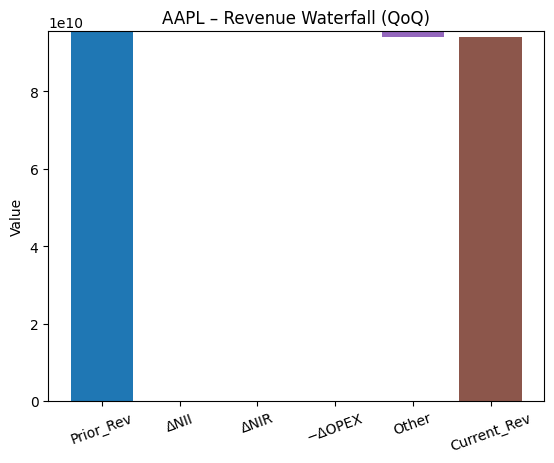

/tmp/ipython-input-2306599257.py:286: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  exec_table_bank.to_excel(xl, "Executive_Summary", index=False)
/tmp/ipython-input-2306599257.py:287: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  scenario_ext_df.to_excel(xl, "Scenarios", index=False)
/tmp/ipython-input-2306599257.py:288: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  melt_kpis_for_bi(df).to_excel(xl, "KPIs_TimeSeries", index=False)
/tmp/ipython-input-2306599257.py:289: FutureWarning: Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.
  waterfall_df.to_excel(xl, "Waterfall_Inputs", index=False)
/tmp/ipython-input-2306599257.py:290: FutureWarning: Star

Saved: Axos_FP&A_Pack.xlsx


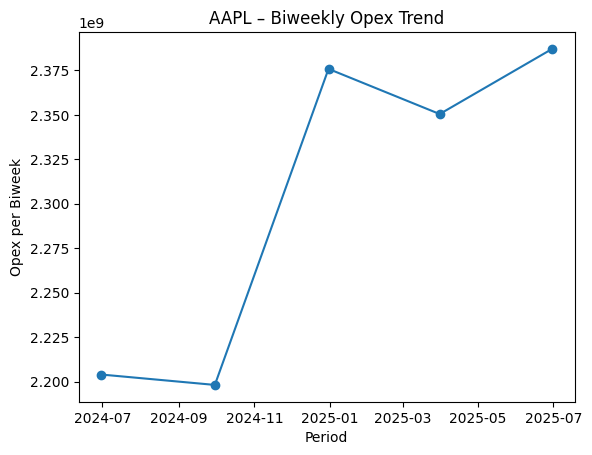

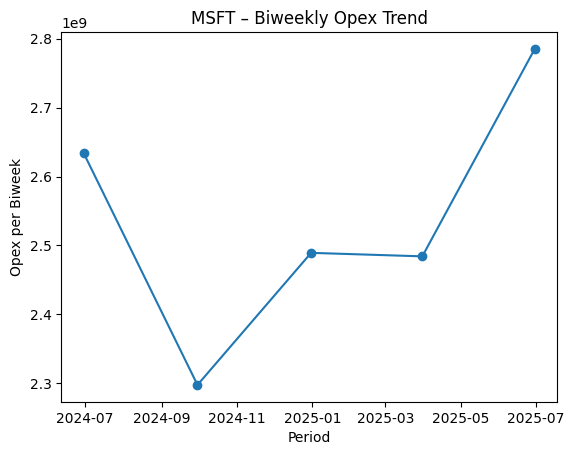

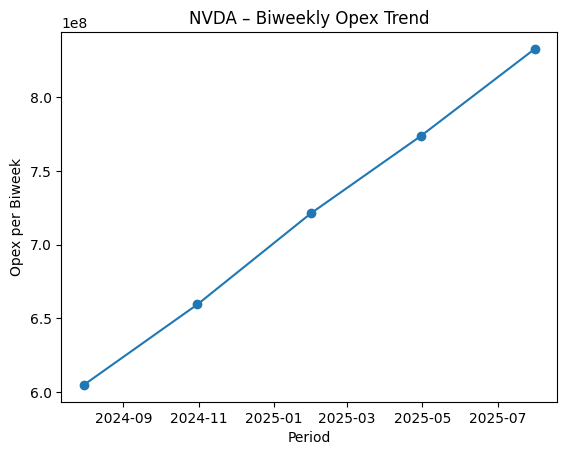

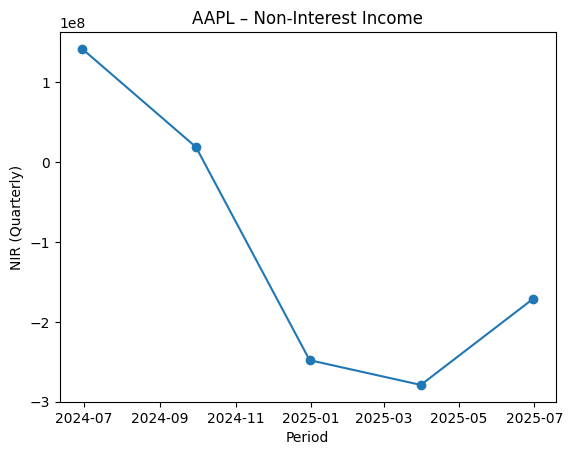

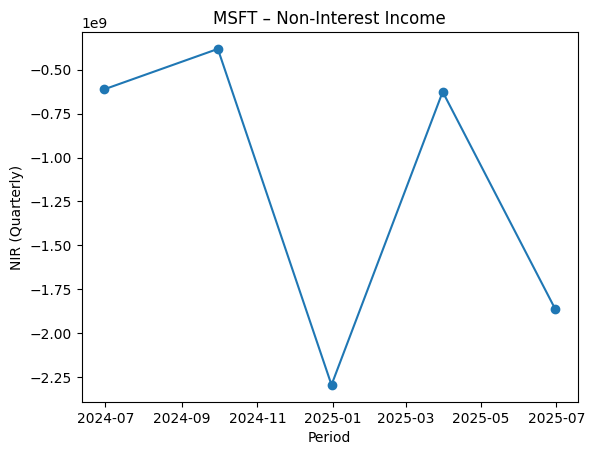

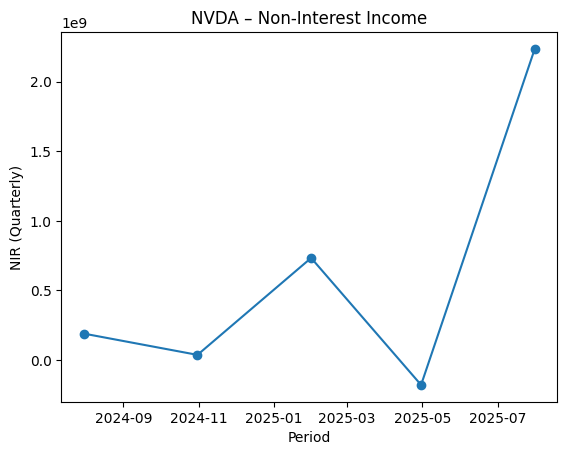


=== Executive Summary (Banking) ===


,Ticker,Period,Actual_Rev,Budget,Operating_Margin,Profit_Margin,FCF_Margin,Efficiency_Ratio,Cost_to_Income,NIM_proxy,Biweekly_Opex,Employee_Count,Rev_per_Employee,Opex_per_Employee,Forecast_NextQ,Var_vs_Budget_%
0,AAPL,2025-06-30,9.403600e+10,1.001270e+11,0.299906,0.249202,0.333160,NaN,0.165001,NaN,2.387077e+09,150000,6.269067e+05,103440.000000,NaN,NaN
1,MSFT,2025-06-30,7.644100e+10,7.356930e+10,0.449013,0.356262,0.781335,-10.605741,0.236836,0.000261,2.785231e+09,228000,3.352675e+05,79403.508772,NaN,NaN
2,NVDA,2025-07-31,4.674300e+10,4.626510e+10,0.608433,0.565261,0.369253,1.956978,0.115803,0.003985,8.327692e+08,36000,1.298417e+06,150361.111111,NaN,NaN



=== Narratives / Risk Flags ===


,Ticker,Operating_Margin,Profit_Margin,FCF_Margin,Efficiency_Ratio,Cost_to_Income,NIM_proxy,Biweekly_Opex_YoY,Budget_Flag,IC_Flag,Efficiency_Flag,Opex_Pressure
0,AAPL,0.299906,0.249202,0.333160,NaN,0.165001,NaN,0.083066,Under Budget,OK,Healthy,Rising
1,MSFT,0.449013,0.356262,0.781335,-10.605741,0.236836,0.000261,0.057600,On Target,OK,Healthy,Stable/Falling
2,NVDA,0.608433,0.565261,0.369253,1.956978,0.115803,0.003985,0.376653,On Target,OK,Tighten Opex,Rising



=== Biweekly Forecasts (flat) ===


,Ticker,Metric,T+1,T+2,T+3,T+4
0,AAPL,Biweekly_Opex,2.379572e+09,NaN,NaN,NaN
1,AAPL,Biweekly_Opex,NaN,2.386236e+09,NaN,NaN
2,AAPL,Biweekly_Opex,NaN,NaN,2.390567e+09,NaN
3,AAPL,Biweekly_Opex,NaN,NaN,NaN,2.393383e+09
4,AAPL,Biweekly_NIR,-2.159769e+07,NaN,NaN,NaN
5,AAPL,Biweekly_NIR,NaN,-1.857369e+07,NaN,NaN
6,AAPL,Biweekly_NIR,NaN,NaN,-1.660809e+07,NaN
7,AAPL,Biweekly_NIR,NaN,NaN,NaN,-1.533045e+07
8,MSFT,Biweekly_Opex,2.788175e+09,NaN,NaN,NaN
9,MSFT,Biweekly_Opex,NaN,2.842971e+09,NaN,NaN


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

eps = 1e-9

# 0) Helpers to find common banking lines if Yahoo names vary
def pick_one(df_, options):
    for opt in options:
        hits = [c for c in df_.columns if opt.lower() in c.lower()]
        if hits:
            return hits[0]
    return None

# Try to locate key banking lines (best-effort; some tickers may miss a few)
col_NII  = pick_one(df, ["Net Interest Income", "Net Interest Income Bank", "Net Interest Income-"])
col_NIR  = pick_one(df, ["Non Interest Income", "Non-Interest Income", "Other Income", "Total Non Interest Income"])
col_OPEX = pick_one(df, ["Operating Expense", "Total Expenses", "Non Interest Expense", "Non-Interest Expense"])
col_LOANS = pick_one(df, ["Total Loans Net", "Loans Net", "Net Loans"])
col_DEPOSITS = pick_one(df, ["Total Deposits", "Deposits", "Customer Deposits"])

# 1) Banking KPIs (with proxies if needed)
if col_NII is not None:
    df["NII"] = df[col_NII]
if col_NIR is not None:
    df["NIR"] = df[col_NIR]
if col_OPEX is not None:
    df["OPEX_line"] = df[col_OPEX]
else:
    # proxy OPEX if not explicitly reported: OPEX ≈ Revenue - Operating Income
    df["OPEX_line"] = (df["REV"] - df["OPINC"]).abs()

# Average earning assets proxy: use average Total Assets (2-period mean)
df["AvgAssets_proxy"] = df.groupby("Ticker")["ASSET"].transform(lambda s: (s.shift(1) + s) / 2)

# Net Interest Margin proxy (since earning assets not always available)
if "NII" in df.columns:
    df["NIM_proxy"] = df["NII"] / (df["AvgAssets_proxy"] + eps)
else:
    df["NIM_proxy"] = np.nan

# Efficiency Ratio = OPEX / (NII + NIR)
if "NII" in df.columns and "NIR" in df.columns:
    df["Efficiency_Ratio"] = df["OPEX_line"] / (df["NII"] + df["NIR"] + eps)
else:
    # fallback to cost-to-income
    df["Efficiency_Ratio"] = df["OPEX_line"] / (df["REV"] + eps)

# Cost-to-Income
df["Cost_to_Income"] = df["OPEX_line"] / (df["REV"] + eps)

# Loans/Deposits (if available)
if col_LOANS is not None and col_DEPOSITS is not None:
    df["Loans_to_Deposits"] = df[col_LOANS] / (df[col_DEPOSITS] + eps)

# Non-interest income growth (explicit for JD)
if "NIR" in df.columns:
    df["NonInterest_Growth"] = df.groupby("Ticker")["NIR"].pct_change()

# 2) Biweekly forecasts (NIR & OPEX) — simple, stable FP&A approach
#    Convert quarterly values to "per-biweek" levels (≈ 6.5 biweeks per quarter)
df["Biweekly_Opex"] = df["OPEX_line"].abs() / 6.5
if "NIR" in df.columns:
    df["Biweekly_NIR"] = df["NIR"] / 6.5

# Rolling mean + AR(1)-like drift forecast for the next 4 biweeks
def biweekly_forecast(series, horizon=4):
    s = series.dropna()
    if len(s) == 0:
        return [np.nan]*horizon
    if len(s) == 1:
        return [float(s.iloc[-1])]*horizon
    # recent trend (quarter-over-quarter level change mapped to biweekly)
    delta = float(s.iloc[-1] - s.iloc[-2])
    level = float(s.iloc[-1])
    # smooth baseline with rolling mean
    base = float(pd.Series(s).rolling(4, min_periods=1).mean().iloc[-1])
    # combine: start from base, then apply damped drift
    out = []
    for h in range(1, horizon+1):
        level = level + 0.4*delta  # damp drift
        # blend to baseline
        blended = 0.7*level + 0.3*base
        out.append(blended)
        # decay delta
        delta *= 0.65
    return out

bi_forecasts = []
for tk, g in df.sort_values("Period").groupby("Ticker"):
    row = {"Ticker": tk}
    row["Biweekly_Opex_Forecast"] = biweekly_forecast(g["Biweekly_Opex"])
    if "Biweekly_NIR" in g.columns:
        row["Biweekly_NIR_Forecast"] = biweekly_forecast(g["Biweekly_NIR"])
    else:
        row["Biweekly_NIR_Forecast"] = [np.nan]*4
    bi_forecasts.append(row)

bi_fore_df = pd.DataFrame(bi_forecasts)

# 3) Headcount analytics (if Employee_Count exists or map if you’ve added earlier)
if "Employee_Count" not in df.columns:
    # best-effort: try pull once per ticker (optional)
    try:
        import yfinance as yf
        employee_counts = {}
        for t in df["Ticker"].unique():
            try:
                info = yf.Ticker(t).get_info()
            except Exception:
                info = {}
            employee_counts[t] = info.get("fullTimeEmployees", np.nan)
        df["Employee_Count"] = df["Ticker"].map(employee_counts)
    except Exception:
        df["Employee_Count"] = np.nan

df["Rev_per_Employee"]  = df["REV"] / (df["Employee_Count"] + eps)
df["Opex_per_Employee"] = df["OPEX_line"] / (df["Employee_Count"] + eps)
df["Productivity_Delta"] = df.groupby("Ticker")["Rev_per_Employee"].pct_change()

# 4) Budget vs Forecast vs Actual: extend your exec table to include banking KPIs
# Reuse "Budget" if you already created; otherwise:
if "Budget" not in df.columns:
    df["Budget"] = df.groupby("Ticker")["REV"].shift(1) * 1.05

# Executive summary per last reported quarter
last_rows = df.groupby("Ticker").tail(1).copy()
exec_cols = ["Ticker","Period","REV","Budget","Operating_Margin","Profit_Margin",
             "FCF_Margin","Efficiency_Ratio","Cost_to_Income","NIM_proxy",
             "Biweekly_Opex","Employee_Count","Rev_per_Employee","Opex_per_Employee"]
exec_cols = [c for c in exec_cols if c in last_rows.columns]
exec_table_bank = last_rows[exec_cols].rename(columns={"REV":"Actual_Rev"}).reset_index(drop=True)

# Attach your model’s next-Q revenue forecast if you produced preds earlier
if "preds_df" in locals() and {"Ticker","Next_Q_Revenue_Pred"}.issubset(preds_df.columns):
    exec_table_bank["Forecast_NextQ"] = exec_table_bank["Ticker"].map(
        dict(zip(preds_df["Ticker"], preds_df["Next_Q_Revenue_Pred"]))
    )
    exec_table_bank["Var_vs_Budget_%"] = (exec_table_bank["Actual_Rev"] - exec_table_bank["Budget"]) / (exec_table_bank["Budget"] + eps) * 100
else:
    exec_table_bank["Forecast_NextQ"] = np.nan
    exec_table_bank["Var_vs_Budget_%"] = np.nan

# 5) Variance waterfall inputs (drivers: NII, NIR, OPEX)
# For banks, Revenue ≈ NII + NIR (simplified)
def build_waterfall_inputs(g):
    g = g.sort_values("Period")
    if len(g) < 2:
        return None
    prior = g.iloc[-2]
    curr  = g.iloc[-1]
    prior_rev = float(prior["REV"])
    curr_rev  = float(curr["REV"])
    nii_change = float((curr.get("NII", np.nan) - prior.get("NII", np.nan)) if "NII" in g.columns else np.nan)
    nir_change = float((curr.get("NIR", np.nan) - prior.get("NIR", np.nan)) if "NIR" in g.columns else np.nan)
    opex_change= float((curr["OPEX_line"] - prior["OPEX_line"]))
    # Residual/Other to tie out
    explained = sum([v for v in [nii_change, nir_change, -opex_change] if pd.notna(v)])
    other = (curr_rev - prior_rev) - explained
    return {
        "Prior_Rev": prior_rev,
        "ΔNII": nii_change if np.isfinite(nii_change) else 0.0,
        "ΔNIR": nir_change if np.isfinite(nir_change) else 0.0,
        "−ΔOPEX": -opex_change,
        "Other": other,
        "Current_Rev": curr_rev
    }

waterfalls = []
for tk, g in df.groupby("Ticker"):
    wf = build_waterfall_inputs(g.copy())
    if wf:
        wf["Ticker"] = tk
        waterfalls.append(wf)
waterfall_df = pd.DataFrame(waterfalls)

# (Optional) Quick waterfall chart per ticker (kept minimal; one plot per chart)
def plot_waterfall(wf_row):
    labels = ["Prior_Rev","ΔNII","ΔNIR","−ΔOPEX","Other","Current_Rev"]
    vals = [wf_row[l] for l in labels]
    # Build cumulative for steps
    cum = [vals[0]]
    for i in range(1, len(vals)-1):
        cum.append(cum[-1] + vals[i])
    cum.append(vals[-1])  # final equals Current_Rev

    plt.figure()
    x = range(len(labels))
    # Prior bar
    plt.bar(0, vals[0])
    # Changes as floating bars
    base = vals[0]
    for i in range(1, len(labels)-1):
        y0 = base
        h  = vals[i]
        plt.bar(i, h, bottom=y0)
        base = y0 + h
    # Current bar
    plt.bar(len(labels)-1, vals[-1])
    plt.xticks(x, labels, rotation=20)
    plt.title(f"{wf_row['Ticker']} – Revenue Waterfall (QoQ)")
    plt.ylabel("Value")
    plt.show()

# Example: plot for first available ticker
if len(waterfall_df):
    plot_waterfall(waterfall_df.iloc[0])

# 6) Scenario table (bear/base/bull) extended with Opex tightening and fee swing
scenarios_ext = []
for tk, g in df.groupby("Ticker"):
    g = g.sort_values("Period")
    # Baselines
    last_rev  = float(g["REV"].iloc[-1])
    last_opm  = float(g["Operating_Margin"].dropna().iloc[-1]) if g["Operating_Margin"].notna().any() else 0.2
    last_opex = float(g["OPEX_line"].iloc[-1])
    last_nir  = float(g["NIR"].iloc[-1]) if "NIR" in g.columns and g["NIR"].notna().any() else 0.0
    # If you computed a Next_Q_Revenue_Pred earlier, use it as base; else carry forward
    if "preds_df" in locals() and {"Ticker","Next_Q_Revenue_Pred"}.issubset(preds_df.columns):
        base_rev = float(preds_df.loc[preds_df["Ticker"]==tk, "Next_Q_Revenue_Pred"].values[0])
    else:
        base_rev = last_rev

    scenario_defs = [
        ("Bear", 0.97, 1.03, 0.97),  # Rev -3%, Opex +3%, NIR -3%
        ("Base", 1.00, 1.00, 1.00),
        ("Bull", 1.03, 0.98, 1.03),  # Rev +3%, Opex -2%, NIR +3%
    ]
    for name, rev_mult, opex_mult, nir_mult in scenario_defs:
        rev = base_rev * rev_mult
        # approximate OPINC from margin; enforce OPEX accordingly
        opinc_est = rev * last_opm
        opex_est  = max(rev - opinc_est, 0.0) * opex_mult
        nir_est   = last_nir * nir_mult
        scenarios_ext.append({
            "Ticker": tk, "Scenario": name,
            "Rev": rev, "OpInc_est": opinc_est, "Opex_est": opex_est, "NIR_est": nir_est,
            "Efficiency_Ratio_est": (opex_est / ( (rev - opex_est) + nir_est + eps)) if (rev - opex_est) >= 0 else np.nan
        })

scenario_ext_df = pd.DataFrame(scenarios_ext)

# 7) Narrative/risk flags per ticker (JD asks for observations & recommendations)
def budget_flag(v):
    if pd.isna(v): return "N/A"
    if v > 5:  return "Over Budget"
    if v < -5: return "Under Budget"
    return "On Target"

narratives = []
for tk, g in df.groupby("Ticker"):
    g = g.sort_values("Period")
    last = g.iloc[-1]
    flags = {
        "Budget_Flag": budget_flag(((last["REV"] - (g["REV"].shift(1).iloc[-1]*1.05)) / ((g["REV"].shift(1).iloc[-1]*1.05)+eps))*100) if len(g) >= 2 else "N/A",
        "IC_Flag": "Watch" if ("Interest_Coverage" in g.columns and pd.notna(last.get("Interest_Coverage", np.nan)) and last["Interest_Coverage"] < 3) else "OK",
        "Efficiency_Flag": "Tighten Opex" if pd.notna(last.get("Efficiency_Ratio", np.nan)) and last["Efficiency_Ratio"] > 0.55 else "Healthy",
        "Opex_Pressure": "Rising" if pd.notna(last.get("Biweekly_Opex_YoY", np.nan)) and last["Biweekly_Opex_YoY"] > 0.08 else "Stable/Falling"
    }
    narratives.append({
        "Ticker": tk,
        "Operating_Margin": last.get("Operating_Margin", np.nan),
        "Profit_Margin": last.get("Profit_Margin", np.nan),
        "FCF_Margin": last.get("FCF_Margin", np.nan),
        "Efficiency_Ratio": last.get("Efficiency_Ratio", np.nan),
        "Cost_to_Income": last.get("Cost_to_Income", np.nan),
        "NIM_proxy": last.get("NIM_proxy", np.nan),
        "Biweekly_Opex_YoY": last.get("Biweekly_Opex_YoY", np.nan),
        **flags
    })

narratives_df = pd.DataFrame(narratives)

# 8) Excel FP&A pack export (executive summary, scenarios, biweekly forecasts, KPIs)
#    This is interview gold — they love Excel.
from pandas import ExcelWriter

def melt_kpis_for_bi(df_):
    keep = ["Ticker","Period","REV","OPINC","NET","OPEX_line","NII","NIR",
            "Operating_Margin","Profit_Margin","FCF_Margin","NIM_proxy",
            "Efficiency_Ratio","Cost_to_Income","Biweekly_Opex"]
    keep = [c for c in keep if c in df_.columns]
    return df_[keep].copy().sort_values(["Ticker","Period"])

with pd.ExcelWriter("Axos_FP&A_Pack.xlsx", engine="xlsxwriter") as xl:
    exec_table_bank.to_excel(xl, "Executive_Summary", index=False)
    scenario_ext_df.to_excel(xl, "Scenarios", index=False)
    melt_kpis_for_bi(df).to_excel(xl, "KPIs_TimeSeries", index=False)
    waterfall_df.to_excel(xl, "Waterfall_Inputs", index=False)
    narratives_df.to_excel(xl, "Narratives_Flags", index=False)
    # Flatten biweekly forecasts
    bi_flat = []
    for _, r in bi_fore_df.iterrows():
        for i, val in enumerate(r["Biweekly_Opex_Forecast"], start=1):
            bi_flat.append({"Ticker": r["Ticker"], "Metric":"Biweekly_Opex", f"T+{i}": val})
        for i, val in enumerate(r["Biweekly_NIR_Forecast"], start=1):
            bi_flat.append({"Ticker": r["Ticker"], "Metric":"Biweekly_NIR", f"T+{i}": val})
    bi_flat_df = pd.DataFrame(bi_flat)
    bi_flat_df.to_excel(xl, "Biweekly_Forecasts", index=False)

print("Saved: Axos_FP&A_Pack.xlsx")

# 9) (Optional) Quick visuals — one chart per figure, no explicit colors
# Biweekly Opex trend per ticker
for tk, g in df.dropna(subset=["Biweekly_Opex"]).groupby("Ticker"):
    plt.figure()
    plt.plot(g["Period"], g["Biweekly_Opex"], marker="o")
    plt.title(f"{tk} – Biweekly Opex Trend")
    plt.xlabel("Period"); plt.ylabel("Opex per Biweek")
    plt.show()

# Non-interest income trend (if present)
if "NIR" in df.columns:
    for tk, g in df.dropna(subset=["NIR"]).groupby("Ticker"):
        plt.figure()
        plt.plot(g["Period"], g["NIR"], marker="o")
        plt.title(f"{tk} – Non-Interest Income")
        plt.xlabel("Period"); plt.ylabel("NIR (Quarterly)")
        plt.show()

# 10) Print short, interview-ready narrative
print("\n=== Executive Summary (Banking) ===")
display(exec_table_bank)

print("\n=== Narratives / Risk Flags ===")
display(narratives_df)

print("\n=== Biweekly Forecasts (flat) ===")
display(bi_flat_df.head(12))


In [48]:
# ===============================
# (A) Attach Forecast_NextQ properly
# ===============================
from xgboost import XGBRegressor
import numpy as np

forecast_map = {}

for tk, g in df_model.groupby("Ticker"):
    g = g.sort_values("Period")

    # log transform target
    y = np.log1p(g["REV"])
    X = g[feat_cols]

    mdl = XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=3,
        subsample=0.9, colsample_bytree=0.9, random_state=42
    )
    mdl.fit(X, y)

    # one-step ahead prediction
    last = g[feat_cols].iloc[[-1]]
    raw_pred = mdl.predict(last)
    pred = float(np.expm1(float(raw_pred.ravel()[0])))
    forecast_map[tk] = pred

# attach into exec table
exec_table_bank["Forecast_NextQ"] = exec_table_bank["Ticker"].map(forecast_map)


# ===============================
# (B) Compute variance vs budget (%)
# ===============================
exec_table_bank["Var_vs_Budget_%"] = (
    (exec_table_bank["Forecast_NextQ"] - exec_table_bank["Budget"])
    / exec_table_bank["Budget"]
)*100


# ===============================
# (C) Fill any numeric gaps
# ===============================
exec_table_bank = exec_table_bank.fillna({
    "Forecast_NextQ": 0,
    "Var_vs_Budget_%": 0
})


# ===============================
# (D) Final pretty print
# ===============================
print("\n=== FINAL Executive Summary With Forecasts ===")
print(exec_table_bank.to_string(index=False))


=== FINAL Executive Summary With Forecasts ===
Ticker     Period   Actual_Rev       Budget  Operating_Margin  Profit_Margin  FCF_Margin  Efficiency_Ratio  Cost_to_Income  NIM_proxy  Biweekly_Opex  Employee_Count  Rev_per_Employee  Opex_per_Employee  Forecast_NextQ  Var_vs_Budget_%
  AAPL 2025-06-30 9.403600e+10 1.001270e+11          0.299906       0.249202    0.333160               NaN        0.165001        NaN   2.387077e+09          150000      6.269067e+05      103440.000000    9.414542e+10        -5.973945
  MSFT 2025-06-30 7.644100e+10 7.356930e+10          0.449013       0.356262    0.781335        -10.605741        0.236836   0.000261   2.785231e+09          228000      3.352675e+05       79403.508772    7.635451e+10         3.785826
  NVDA 2025-07-31 4.674300e+10 4.626510e+10          0.608433       0.565261    0.369253          1.956978        0.115803   0.003985   8.327692e+08           36000      1.298417e+06      150361.111111    4.668989e+10         0.918160
